# ============================================
# Module 9b: Foundations of Training & Transformers
# Lab 1 – Data Splits & Cross-Validation (TweetEval Sentiment, 3 classes)
# ============================================
**Author:** Dr. Dasha Trofimova  
**Course:** M.Sc. Applied Data Science & AI

### Learning Goals
- Understand training/validation/test splits and their roles
- Run and visualize 5-fold cross-validation
- Evaluate a simple, fast NLP baseline (TF-IDF + Logistic Regression)
- Interpret confusion matrices and metrics

---


In [ ]:
!pip install datasets scikit-learn matplotlib seaborn --quiet

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

sns.set(style="whitegrid", context="talk")
np.random.seed(42)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Labels: ['negative', 'neutral', 'positive']


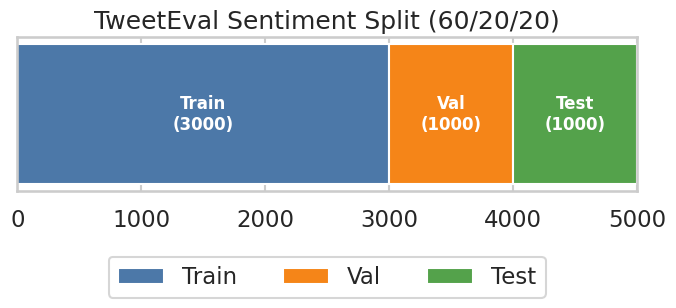

/tmp/ipython-input-3529478547.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2", ax=ax)
/tmp/ipython-input-3529478547.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_names); ax.set_title("Label Distribution (Train)")


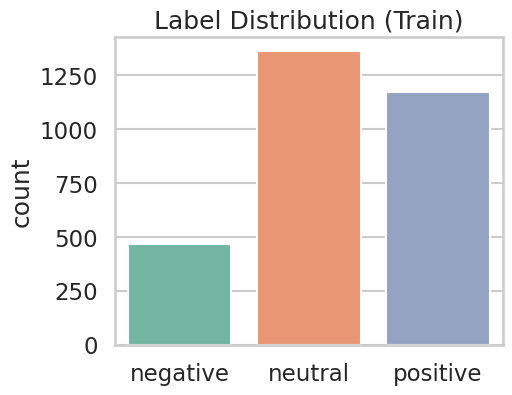

In [ ]:
# Load TweetEval Sentiment (3-class: negative, neutral, positive)
raw = load_dataset("tweet_eval", "sentiment")

# Downsample to keep notebook snappy
train_small = raw["train"].shuffle(seed=42).select(range(5000))
test_small  = raw["test"].shuffle(seed=42).select(range(2000))

label_names = raw["train"].features["label"].names
print("Labels:", label_names)

X = [ex["text"] for ex in train_small]
y = [ex["label"] for ex in train_small]

# Train/Val/Test Split 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Split bars
sizes = [len(X_train), len(X_val), len(X_test)]
labels_bars = [f"Train\n({sizes[0]})", f"Val\n({sizes[1]})", f"Test\n({sizes[2]})"]

fig, ax = plt.subplots(figsize=(8,2))
ax.barh([0], [sizes[0]], color="#4C78A8", label="Train")
ax.barh([0], [sizes[1]], left=[sizes[0]], color="#F58518", label="Val")
ax.barh([0], [sizes[2]], left=[sizes[0]+sizes[1]], color="#54A24B", label="Test")
ax.set_yticks([]); ax.set_xlim(0, sum(sizes)); ax.set_title("TweetEval Sentiment Split (60/20/20)")
for i,(s,lx) in enumerate(zip(sizes,[0, sizes[0], sizes[0]+sizes[1]])):
    ax.text(lx + s/2, 0, labels_bars[i], va="center", ha="center", color="white", fontsize=12, weight="bold")
ax.legend(ncol=3, bbox_to_anchor=(0.5, -0.35), loc="upper center")
plt.show()

# Label distribution
fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(x=y_train, palette="Set2", ax=ax)
ax.set_xticklabels(label_names); ax.set_title("Label Distribution (Train)")
plt.show()

### 🎯 Quick Card Quiz — Data Splits (Raise your color card!)

**Color legend (match the bar colors):**  
- **Blue = Train**, **Orange = Validation**, **Green = Test**

1) **Which split do we monitor to detect *overfitting*?**  
2) **Which split is used *exactly once* at the very end, after all modeling decisions are frozen?**
3) **During 5-fold cross-validation, which pool is rotated into the validation fold while the other folds are used for fitting?**


/tmp/ipython-input-3266180199.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=values, palette=palette, ax=ax)
/tmp/ipython-input-3266180199.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=values, palette=palette, ax=ax)
/tmp/ipython-input-3266180199.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=values, palette=palette, ax=ax)


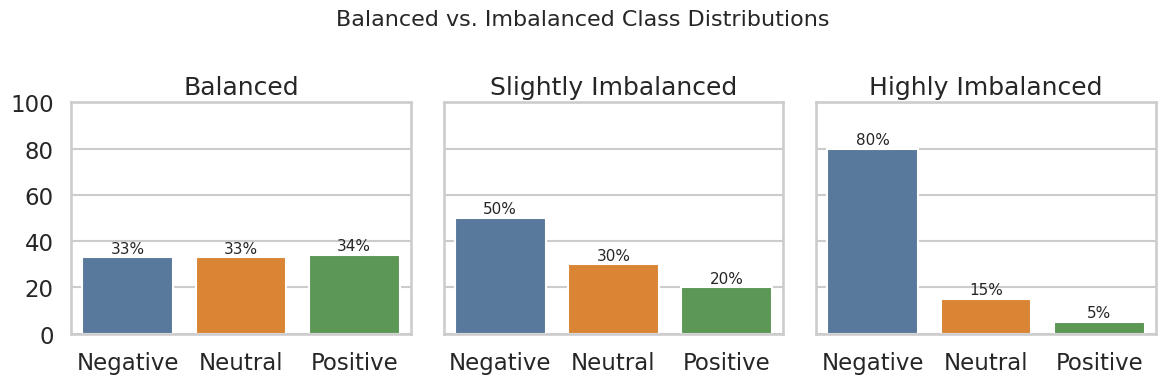

In [ ]:

# 🧮 Visualizing Balanced vs. Imbalanced Class Distributions

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")

classes = ["Negative", "Neutral", "Positive"]
scenarios = {
    "Balanced": [33, 33, 34],
    "Slightly Imbalanced": [50, 30, 20],
    "Highly Imbalanced": [80, 15, 5],
}

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
palette = ["#4C78A8", "#F58518", "#54A24B"]

for ax, (title, values) in zip(axes, scenarios.items()):
    sns.barplot(x=classes, y=values, palette=palette, ax=ax)
    ax.set_ylim(0, 100)
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, v + 2, f"{v}%", ha="center", fontsize=11)

fig.suptitle("Balanced vs. Imbalanced Class Distributions", fontsize=16)
plt.tight_layout()
plt.show()



### 🎯 Quick Card Quiz — Data Distributions & Balance

**Color legend (same cards):**  
- **Blue = Balanced dataset**  
- **Orange = Slightly imbalanced dataset**  
- **Green = Highly imbalanced dataset**

1. **If one class dominates 80% of the data, what problem might occur?**  
   
2. **If you want your model to see all sentiment classes equally during training, which bar chart shape do you want?**  

3. **If your dataset is imbalanced, what metric is more reliable than accuracy?**

/tmp/ipython-input-690224469.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Fold {i+1}" for i in range(5)], y=cv_scores, ax=ax, palette="crest")


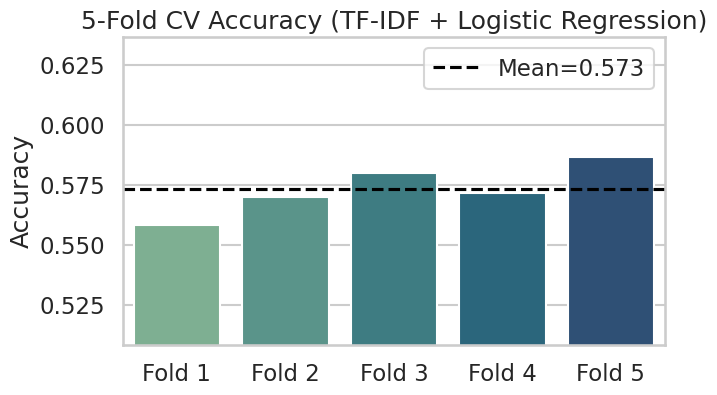

Fold scores: [0.558 0.57  0.58  0.572 0.587]
Mean CV accuracy: 0.573  |  Std: 0.010


In [ ]:
# 5-fold CV on TRAIN (TF-IDF + Logistic Regression)
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=15_000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="accuracy")

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=[f"Fold {i+1}" for i in range(5)], y=cv_scores, ax=ax, palette="crest")
ax.axhline(cv_scores.mean(), ls="--", color="black", label=f"Mean={cv_scores.mean():.3f}")
ax.set_ylim(max(0.4, cv_scores.min()-0.05), cv_scores.max()+0.05); ax.set_ylabel("Accuracy")
ax.set_title("5-Fold CV Accuracy (TF-IDF + Logistic Regression)"); ax.legend()
plt.show()

print(f"Fold scores: {np.round(cv_scores,3)}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f}  |  Std: {cv_scores.std():.3f}")

Test Accuracy: 0.583

              precision    recall  f1-score   support

    negative      0.500     0.090     0.153       155
     neutral      0.559     0.740     0.637       454
    positive      0.628     0.596     0.612       391

    accuracy                          0.583      1000
   macro avg      0.562     0.475     0.467      1000
weighted avg      0.577     0.583     0.552      1000



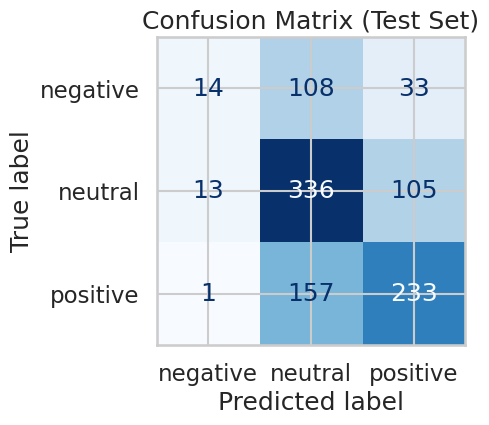

In [ ]:
# Train on TRAIN+VAL, evaluate on TEST (confusion matrix + report)
X_trainval = X_train + X_val
y_trainval = y_train + y_val

pipe.fit(X_trainval, y_trainval)
y_pred = pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_acc:.3f}\n")
print(classification_report(y_test, y_pred, target_names=label_names, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_names, ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (Test Set)"); plt.show()